In [1]:
import skimage
import skimage.io
import scipy.io
import os, sys
import utils
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

## Calculate the mean landmark and train data X

In [2]:
landmark_folder = os.path.join(os.getcwd(), "landmarks")
files = utils.files_under_folder_with_suffix(landmark_folder, suffix = '.mat')

In [ ]:
train_set = files[:800]

In [ ]:
mean_LM, X = utils.LM_mean_LM_data(landmark_folder, train_set)

In [ ]:
mdict = {"mean_landmark": mean_LM, "train_data": X}
scipy.io.savemat("PCA_Train_Data_LandMark.mat", mdict)

## Read in the mean landmark

In [3]:
mdict = scipy.io.loadmat("PCA_Train_Data_LandMark.mat")
mean_LM = mdict["mean_landmark"]
X = mdict["train_data"]

In [4]:
print(mean_LM.shape, X.shape)

(1, 136) (800, 136)


In [5]:
X_center = X - mean_LM

In [6]:
Pseudo_Cov_Matrix = np.matmul(X_center, np.transpose(X_center))

In [7]:
P_eigen_vector, P_engen_value, _ = np.linalg.svd(Pseudo_Cov_Matrix)

## Calculate first 50 eigen-warping

In [8]:
for i in range(50):
    if i == 0:
        cur_warping = np.matmul(np.transpose(X_center), P_eigen_vector[:, i])
        eigen_warping =  np.expand_dims(cur_warping / np.sqrt(np.dot(cur_warping, cur_warping)), axis = 0)
    else:
        cur_warping = np.matmul(np.transpose(X_center), P_eigen_vector[:, i])
        eigen_warping = np.concatenate((eigen_warping, np.expand_dims(cur_warping / np.sqrt(np.dot(cur_warping, cur_warping)), axis = 0)), axis = 0)

In [9]:
Eigen_warping = eigen_warping + mean_LM

In [10]:
Eigen_warping = np.reshape(Eigen_warping, (Eigen_warping.shape[0], int(Eigen_warping.shape[1] / 2), 2 ))

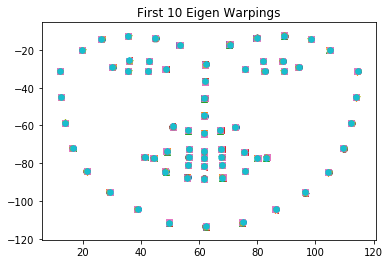

In [11]:
fig = plt.figure()
plt.clf()
marker_style = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
for i in range(10):
    plt.scatter(Eigen_warping[i, :, 0], -Eigen_warping[i, :, 1], marker = marker_style[i])
plt.title("First 10 Eigen Warpings")
plt.show()
fig.savefig("5_10_eigen_warpings.png")

## Reconstructed Loss

In [12]:
test_set = files[800:]

In [13]:
_, X_test = utils.LM_mean_LM_data(landmark_folder, test_set)

In [14]:
X_center = X_test - mean_LM

In [15]:
K = [x for x in range(0, 55, 5)]
K[0] = 1
Loss = []
for k in K:
    loss = utils.reconstructed_loss_landmark(X_center, eigen_warping[: k, :])
    Loss.append(loss)

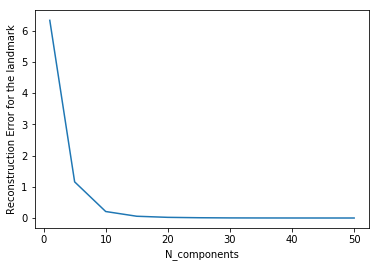

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(K, Loss)
plt.xlabel("N_components")
plt.ylabel("Reconstruction Error for the landmark")
plt.show()
plt.savefig("6_reconstructed_error_landmark.png")

In [ ]:
eigen_v = eigen_warping[:10, :]
coef = np.matmul(X_center, eigen_v.T)
print(coef.shape)

In [ ]:
recons = np.matmul(coef, eigen_v)
print(recons.shape)

In [ ]:
loss = np.square(X_center - recons)
loss = np.sum(loss)/(loss.shape[0] * loss.shape[1])
loss